In [1]:
#to reflect changes made in modules
%load_ext autoreload
%autoreload 2

#setup
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import machine_learning
import clean_read_data
from sklearn.model_selection import train_test_split

# Project Introduction
The big idea of our project is to Explore the correlation between gun violence cases with gun reform laws in the area. One main question that we are investigating is has gun reform impacted the number of gun violence cases in the US? We have multiple datasets that show gun-related cases by state and year, firearm laws passed by states, and state populations. The scope of our project is to visualize the number of gun cases in the US using the Gun Violence dataset from the Gun Violence Archive.


# Data Reading and Cleaning

Because of GitHub storage limits, we could not include our `gun-violence-data_01-2013_03-2018.csv` in this repository. If you would like to run the code below, you will have to download the dataset yourself at https://github.com/jamesqo/gun-violence-data#how-did-you-get-the-data by going to the section "How did you get the data" and following the steps under "stage 3" to download and unpack the tar.gz file. Once you unpack the tar.gz file, you should have a file named stage3.csv. This is the same file as our `gun-violence-data_01-2013_03-2018.csv`, but we renamed the file. You will also have to rename the file from 'stage3.csv' to 'gun-violence-data_01-2013_03-2018.csv'.

In [2]:
# Reading in data for gun violence counts and firearm laws
gun_data = pd.read_csv('gun-violence-data_01-2013_03-2018.csv')
gunlaws = pd.read_csv('statefirearmlaws.csv')

gun_data, missing_row, gun_laws = clean_read_data.read_data(gun_data, gunlaws)

gun_data = pd.read_csv('gun-violence-data_01-2013_03-2018.csv')
gun_data = clean_read_data.clean_data(gun_data)
gun_data.head(4)

,incident_id,date,state,n_killed,n_injured,incident_url,congressional_district,incident_characteristics,participant_age,participant_age_group,participant_gender,participant_status,participant_type,state_house_district,state_senate_district,year
296,92342,2014-01-01,Alabama,1,0,http://www.gunviolencearchive.org/incident/92342,5.0,"Shot - Dead (murder, accidental, suicide)",0::21||1::24,0::Adult 18+||1::Adult 18+,0::Female||1::Male,0::Killed||1::Unharmed,0::Victim||1::Subject-Suspect,19.0,7.0,2014
315,94194,2014-01-01,Alabama,0,3,http://www.gunviolencearchive.org/incident/94194,4.0,Home Invasion||Home Invasion - Resident injure...,3::17||4::19||5::19||6::19,3::Teen 12-17||4::Adult 18+||5::Adult 18+||6::...,0::Male||1::Male||2::Female||3::Male||4::Male|...,0::Injured||1::Injured||2::Injured||3::Unharme...,0::Victim||1::Victim||2::Victim||3::Subject-Su...,61.0,21.0,2014
320,92337,2014-01-01,Alabama,1,0,http://www.gunviolencearchive.org/incident/92337,2.0,"Shot - Dead (murder, accidental, suicide)",0::18||1::19,0::Adult 18+||1::Adult 18+,0::Female||1::Male,0::Killed||1::Unharmed,0::Victim||1::Subject-Suspect,90.0,25.0,2014
383,95279,2014-01-01,Alabama,0,1,http://www.gunviolencearchive.org/incident/95279,4.0,Shot - Wounded/Injured,0::73,0::Adult 18+,0::Female,0::Injured,0::Victim,28.0,10.0,2014


We processed our data by filtering out the necessary rows and columns based on the year range that best applied to all of our datasets, missing values, and features that most directly impact our EDA. We applied this process to all of our datasets (gun violence, state firearm laws, gun reform). 

# Exploratory Data Analysis
The datasets that we are using contain information about gun violence incidents from 2013-2018, gun reform laws from 1991-2020, and state populations from 2010-2019. The Gun Violence dataset indicates that there has been an increase in gun violence from 2014 to 2017. Additionally, there has been an overall increase in gun reform laws across the US, which led us to explore whether gun reform laws have an impact on gun violence at the state level.

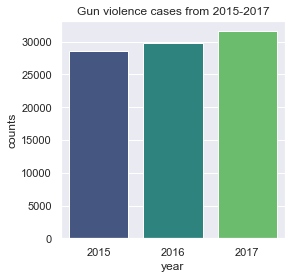

In [3]:
gun_data['date'] = pd.to_datetime(gun_data['date'])
gun_data['year'] = gun_data['date'].dt.year
gun_data_year = gun_data
gun_data_year = gun_data_year.groupby(['year']).size().reset_index(name='counts');

sns.set(rc = {'figure.figsize':(4,4)});
sns.barplot(x="year", y="counts", data=gun_data_year.loc[1:4, :], palette='viridis').set(title="Gun violence cases from 2015-2017");

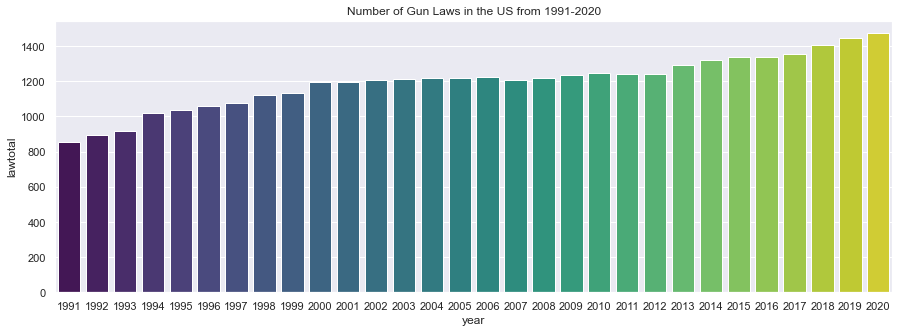

In [4]:
gun_laws_year = gun_laws.groupby(['year']).sum().reset_index()
sns.set(rc = {'figure.figsize':(15,5)});
sns.barplot(x='year', y='lawtotal', data=gun_laws_year, palette='viridis').set(title='Number of Gun Laws in the US from 1991-2020');

# At least one visualization that tests an interesting hypothesis


The hypothesis that we will be testing is that states with more strict gun laws have a smaller amount of gun violence incidents compared to states with less strict gun laws.

,state,counts
13,Illinois,12845
4,California,8087
9,Florida,7387
32,New York,6881


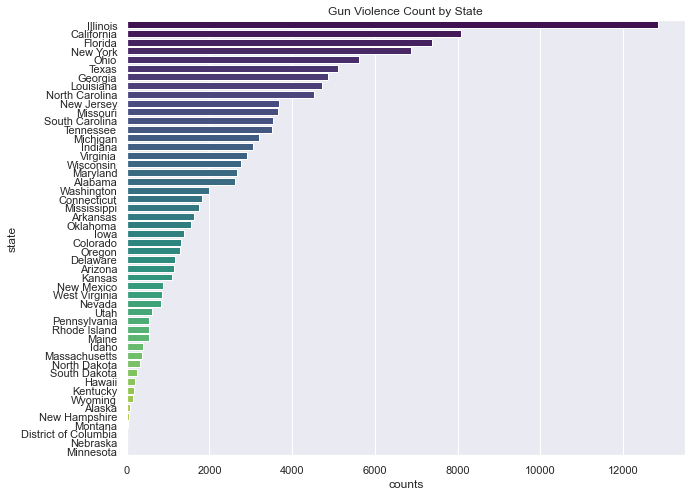

In [5]:
df_state = gun_data.groupby(['state']).size().reset_index(name='counts')
df_state = df_state.sort_values(by='counts', ascending=False)
sns.set(rc = {'figure.figsize':(10,8)})
sns.barplot(x='counts', y='state', data=df_state, palette='viridis').set(title="Gun Violence Count by State");

df_state.head(4)

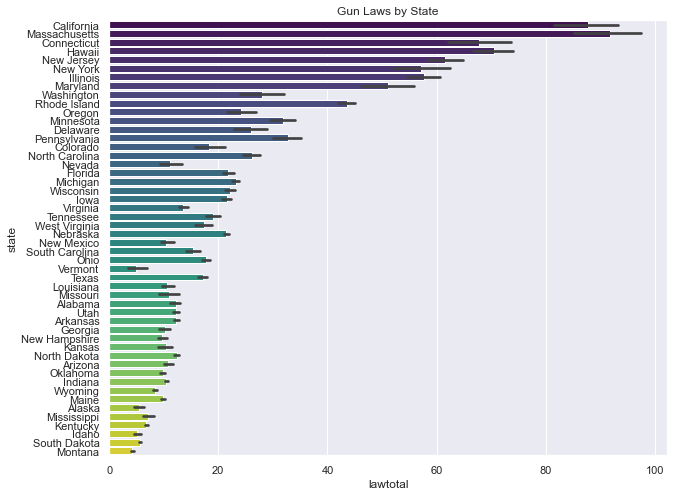

In [6]:
df_laws = gun_laws.sort_values(by='lawtotal', ascending=False)
sns.set(rc = {'figure.figsize':(10,8)})
sns.barplot(x='lawtotal', y='state', data=df_laws, palette='viridis').set(title="Gun Laws by State");

Looking at the visualizations, Illinois has the highest gun violence incidents and Hawaii has the least number of incidents. However, the population difference is very large. Because of this, we will calculate a proportion that represents (# of cases/ population). 


In [7]:
uspopulation = pd.read_csv('us_states_census.csv') 
population = pd.DataFrame(data=uspopulation, columns=['state','2013','2014','2015','2016','2017', '2018'])

state_cases = gun_data.groupby(['state']).size().reset_index(name='counts')
state_cases = state_cases.sort_values(by='state', ascending=True)
state_cases['population'] = population['2018']

prop_cases = population
prop_cases['prop_cases'] = state_cases['counts'] / population['2018']
prop_cases = prop_cases.sort_values(by=['prop_cases'], ascending=False)

In [8]:
prop_cases.head(2)

,state,2013,2014,2015,2016,2017,2018,prop_cases
45,Vermont,626210.0,625214.0,625216.0,623657.0,624344.0,624358.0,0.004640
48,West Virginia,1853914.0,1849489.0,1842050.0,1831023.0,1817004.0,1804291.0,0.001535


In [9]:
prop_cases.tail(1)

,state,2013,2014,2015,2016,2017,2018,prop_cases
50,Wyoming,582122.0,582531.0,585613.0,584215.0,578931.0,577601.0,NaN


Looking at the new proportion calculations, we will compare the proportion of cases between **Alaska** and **Hawaii** and if the number of laws affects the proportion.


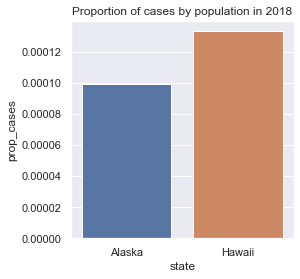

In [10]:
top_state_inc = pd.DataFrame(population[population['state'] == 'Alaska'])
low_state_inc = pd.DataFrame(population[population['state'] =='Hawaii'])

list_states_inc = [top_state_inc, low_state_inc]
stats_inc = pd.concat(list_states_inc)
stats_inc
sns.set(rc = {'figure.figsize':(4,4)});
sns.barplot(data=stats_inc, x="state", y="prop_cases").set(title="Proportion of cases by population in 2018");


In Alaska, roughly 3 laws were passed each year between 2013 and 2018, and the proportion of cases by population is 0.001835. In Hawaii, roughly 79-80 laws were added by 2018. There is a lower proportion, 0.000203. 

# Hypothesis Results

Our hypothesis is correct. Alaska has one of the  highest proportions of gun-related incidents by population, but a lower number of gun laws. Hawaii has a lower proportion of gun-related incidents by population, and a higher number of gun laws passes. Given that our hypothesis was that states with low gun-related incidents have higher gun laws, and vice versa, our hypothesis was correct. 

In [11]:
import scipy
df_states = pd.read_csv('df_states.csv')
stat, p = scipy.stats.pearsonr(df_states['per_counts'], df_states['lawtotal'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('There is not enough evidence to reject H0. Probably independent')
else:
	print('There is enough evidence to reject H0. Probably dependent')
# law_tatoal vs. gun_violence_counts per 10000 people

stat=-0.183, p=0.204
There is not enough evidence to reject H0. Probably independent


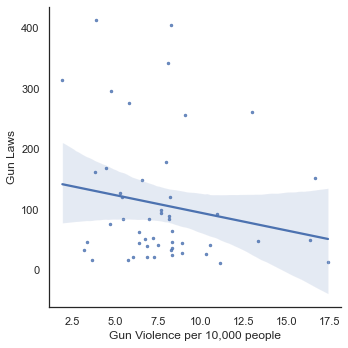

In [12]:
sns.set_style('white')
ax = sns.lmplot(x="per_counts", y="lawtotal", data=df_states, scatter_kws={'s': 6}, legend=True)
ax.set(ylabel="Gun Laws")
ax.set(xlabel="Gun Violence per 10,000 people");

# ML Analysis: Data Cleaning + Feature Engineering

In this section, we merge the gun reform and gun violence data, add additional features and our target variable, and oversample to balance classes. 
- We calculate `proportion_harmed` by dividing the number of people injured in a gun violence incident by the state's population that year. 
- Our target variable is  `decrease_in_gun_violence` which is measured by comparing the proportion of people harmed (killed or injured) for a state's current and previous years from the time frame of 2014-2017. Thus, each state in our data set `data` has an entry for 2015, 2016, and 2017. 

- Using Alabama as an example of how we determine the target variable for each state+year, there are three entries in our dataset: Alabama 2015, Alabama 2016, and Alabama 2017. Alabama 2015's value for `decrease_in_gun_violence` is determined by looking at the proportion of people harmed in the previous year, Alabama 2014, and the proportion of people harmed in the current row's year, Alabama 2015. If there is a decrease in proportion of people harmed then `decrease_in_gun_violence=True`. Otherwise `decrease_in_gun_violence=False`. The same process is repeated to get target variable values for Alabama 2016 and Alabama 2017. 


In [13]:
#clean and merge data set for ML 
gun_cases = 'gun-violence-data_01-2013_03-2018.csv'
gun_laws = 'statefirearmlaws.csv'
population = 'us_states_census.csv'
data = machine_learning.combineDatasets(gun_cases, gun_laws, population)
data.head(4)

,state,year,proportion_harmed,decrease_in_gun_violence,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,...,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking,lawtotal
0,Alabama,2015,0.000195,False,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,10
1,Alabama,2016,0.000257,False,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,10
2,Alabama,2017,0.000287,False,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,10
3,Alaska,2015,0.000209,False,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [14]:
#oversampling from decrease_in_gun_violence=1 to balance classes out
oversampled_rows = data[data.decrease_in_gun_violence == True].copy(deep=True)
balanced_data = pd.concat([data, oversampled_rows], ignore_index=True)

#create features and labels for ML application. Label is (0,1) based on 
#whether a decrease in gun_violence was observed
X, y = machine_learning.create_features_labels(balanced_data)

#the proportion of classes w.r.t 'decrease_in_gun_violence' (0,1) are now balanced
print(f'Number of examples in our dataset where decrease_in_gun_violence=0: {len(y[y == 0])}')
print(f'Number of examples in our dataset where decrease_in_gun_violence=1: {len(y[y == 1])}')

Number of examples in our dataset where decrease_in_gun_violence=0: 101
Number of examples in our dataset where decrease_in_gun_violence=1: 98


# ML Baseline Classifier

In [15]:
#building our baseline classifier (predicts the majority label)
baseline = machine_learning.MajorityLabelClassifier()
baseline.fit(X, y)
labels = baseline.predict(X)
print(baseline.evaluate_accuracy(y, labels))

0.6838235294117647


# ML Linear SVM

In [16]:
#cross validation to determine best kernel
kf = sklearn.model_selection.KFold(n_splits=4, random_state=1, shuffle=True) #5-fold cross validation
print(kf)

#reset indices of X_train and y_train to avoid indexing errors during CV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=1) #changed split to 80% train, 20% test
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

#use CV to find the best_kernel for our SVC model
svm = machine_learning.SVM()
best_kernel = svm.best_model_selection(kf, X_train, y_train)
print(f'Best kernel selected via cross-validation: {best_kernel}')

KFold(n_splits=4, random_state=1, shuffle=True)
{'linear': 0.5407051282051282, 'rbf': 0.452724358974359, 'poly': 0.49022435897435895, 'sigmoid': 0.515224358974359}
Best kernel selected via cross-validation: linear


SVC(kernel='linear')
Train Accuracy: 0.6633165829145728
Test Accuracy: 0.4
precision: [0.47058824 0.34782609]
recall   : [0.34782609 0.47058824]
f1 score : [0.4 0.4]


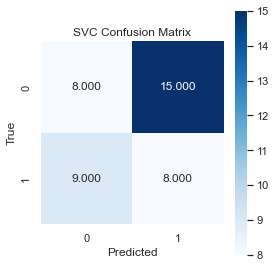

In [17]:
#train and predict classifier
classifier = svm.learn_classifier(X_train, y_train, kernel=best_kernel)
y_predict = classifier.predict(X_test)

print(classifier)
svm.display_metrics(X, y, y_test, y_predict)

# ML Analysis: Decision Tree

Train Accuracy: 0.9346733668341709
Test Accuracy: 0.7
precision: [0.78947368 0.61904762]
recall   : [0.65217391 0.76470588]
f1 score : [0.71428571 0.68421053]


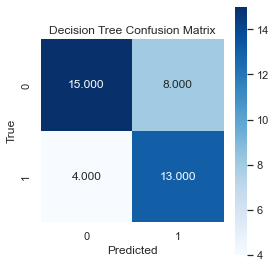

In [18]:
#evaluating our Decision Tree classifier by training, fitting, and predicting on our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=1) #changed split to 80% train, 20% test

decision_tree = machine_learning.DecisionTree()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

decision_tree.display_metrics(X, y, y_test, y_pred)

# Results + Reflection 



In our work of applying machine learning to predict if gun reform leads to a decrease in gun violence, the `decision tree classifier` yielded the best results, although only with an accuracy of **70%**. Since our decrease_in_gun_violence classes in our dataset were heavily imbalanced, we performed oversampling and ended up with 101 examples of class decrease_in_gun_violence=0 (no decrease) and 98 examples of class decrease_in_gun_violence=1 (yes decrease). The oversampling helped our decision tree improve its accuracy from the version we submitted in the progress report, and thus we ended up with the current and final 70% accuracy. The linear svm we trained on the oversampled dataset did not better than our baseline classifier and only provided a **40%** accuracy even after implementing cross validation to select the best kernel. 

To improve the predicition performance of our decision tree model's ability to determine if gun violence will decrease with gun reform laws, we suggest the following considerations:
- reducing the dimension of attributes with regards to the columns providing the counts of each type of gun reform law. In our merged dataset used to train our models, columns 5-138 were counts of each type of individual law. We suggest perfoming additional feature transformation by either aggregating these counts, or taking the top X most significant columns. 
- engineer more creative and representative features to capture the scope of our problem. This entails conducting further research as to the underlying factors and causes of gun violence on the data scientist's end to gain a more informed view and understanding of the task at hand. 
- incorporating socioeconomic data by region. 

Overall, our group was able to takeaway a more informed understanding of the role of gun reform to prevent gun violence. Gun violence is influenced by several factors, which makes it hard to attribute what exactly the trend in gun violence corresponds to. The expectation of introducing additional gun reform is that gun violence will decrease, but several socioeconomic and additional factors may offset this expectation.